In [1]:
"""
1) Go into the folder Action/Action and read up to 5000 lines from each .txt file (which is an action movie script)
2) For each .txt file, corresponding to a movie, create a node for a graph
3) Nodes should be highly connected if the scripts are similar
4) Plot the overall movie network graph, with nodes labeled by numbers, and a legend below with short versions of the movie titles that correspond to the numbers.
"""

'\n1) Go into the folder Action/Action and read up to 5000 lines from each .txt file (which is an action movie script)\n2) For each .txt file, corresponding to a movie, create a node for a graph\n3) Nodes should be highly connected if the scripts are similar\n4) Plot the overall movie network graph, with nodes labeled by numbers, and a legend below with short versions of the movie titles that correspond to the numbers.\n'

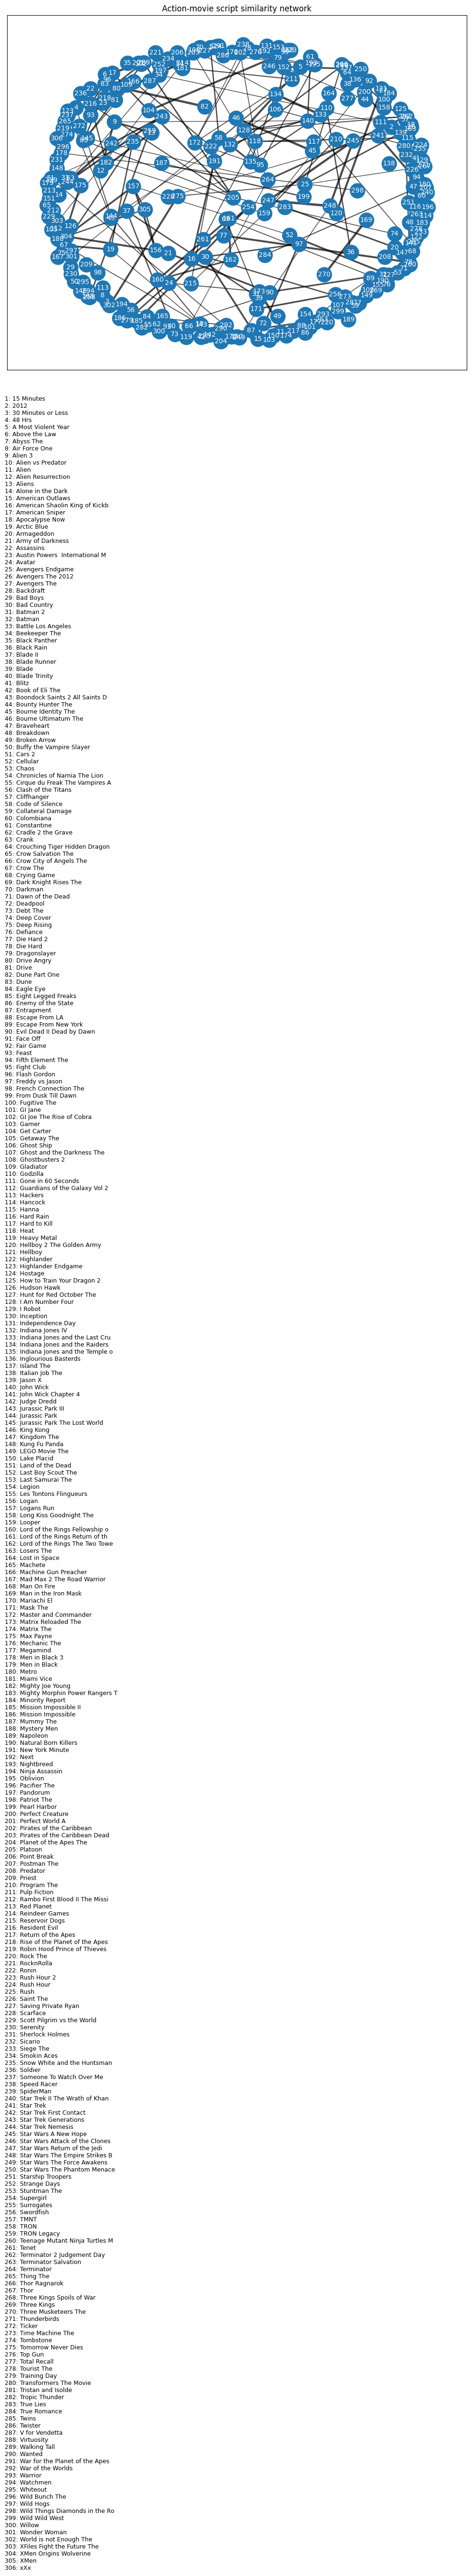


Pairwise script cosine-similarity:
                                                            15 Minutes   2012  30 Minutes or Less  48 Hrs_  A Most Violent Year  Above the Law  Abyss_ The  Air Force One  Alien 3  Alien vs_ Predator  Alien  Alien_ Resurrection  Aliens  Alone in the Dark  American Outlaws  American Shaolin_ King of Kickboxers II  American Sniper  Apocalypse Now  Arctic Blue  Armageddon  Army of Darkness  Assassins  Austin Powers _ International Man of Mystery  Avatar  Avengers_ Endgame  Avengers_ The _2012_  Avengers_ The  Backdraft  Bad Boys  Bad Country  Batman 2  Batman  Battle_ Los Angeles  Beekeeper_ The  Black Panther  Black Rain  Blade II  Blade Runner  Blade  Blade_ Trinity  Blitz  Book of Eli_ The  Boondock Saints 2_ All Saints Day  Bounty Hunter_ The  Bourne Identity_ The  Bourne Ultimatum_ The  Braveheart  Breakdown  Broken Arrow  Buffy the Vampire Slayer  Cars 2  Cellular  Chaos  Chronicles of Narnia_ The Lion_ the Witch and the Wardrobe  Cirque du Freak_ 

In [4]:
#!/usr/bin/env python3
# build_script_graph_with_df.py
# Create a similarity graph from movie scripts in Action/Action
# and display the full similarity matrix as a DataFrame

import os
import re
import glob
import itertools

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

# ─── parameters ──────────────────────────────────────────────────────────────
SCRIPT_DIR    = "Action/Action"
MAX_LINES     = 5000           # read at most this many lines per script
SIM_THRESHOLD = 0.25           # connect nodes if cosine-sim ≥ this value
TOP_N_EDGES   = 5              # keep top-k strongest edges per node

# ─── load scripts ────────────────────────────────────────────────────────────
paths  = sorted(glob.glob(os.path.join(SCRIPT_DIR, "*.txt")))
titles = []
docs   = []

for path in paths:
    with open(path, "r", encoding="utf-8", errors="ignore") as fh:
        lines = list(itertools.islice(fh, MAX_LINES))
    title = os.path.splitext(os.path.basename(path))[0]
    titles.append(title)
    docs.append(" ".join(lines))

# ─── vectorise & compute similarity ──────────────────────────────────────────
tfidf = TfidfVectorizer(min_df=2, max_df=0.9, stop_words="english")
X     = tfidf.fit_transform(docs)
sim   = cosine_similarity(X)  # shape (n_movies, n_movies)

# ─── build graph ─────────────────────────────────────────────────────────────
G = nx.Graph()
n = len(titles)
for idx, t in enumerate(titles):
    G.add_node(idx + 1, title=t)  # nodes numbered from 1

for i in range(n):
    if TOP_N_EDGES:
        neighbors = sim[i].argsort()[-(TOP_N_EDGES + 1):][::-1]
    else:
        neighbors = [j for j in range(n) if j != i and sim[i, j] >= SIM_THRESHOLD]

    for j in neighbors:
        if i == j:
            continue
        weight = float(sim[i, j])
        if weight < SIM_THRESHOLD:
            continue
        G.add_edge(i + 1, j + 1, weight=weight)

# ─── plot the graph ──────────────────────────────────────────────────────────
pos = nx.spring_layout(G, k=0.45, seed=42, weight="weight")
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="#1f77b4")
nx.draw_networkx_edges(
    G,
    pos,
    width=[d["weight"] * 4 for *_, d in G.edges(data=True)],
    alpha=0.7
)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="white")

labels = [
    f"{idx}: {re.sub('[^A-Za-z0-9 ]','', titles[idx-1])[:30]}"
    for idx in G.nodes
]
plt.figtext(0.01, -0.05, "\n".join(labels), ha="left", va="top", fontsize=9, wrap=True)

plt.title("Action-movie script similarity network")
plt.tight_layout()
plt.show()

# ─── display full similarity matrix as a DataFrame ─────────────────────────
sim_df = pd.DataFrame(sim, index=titles, columns=titles)
# round for readability
sim_df = sim_df.round(3)

print("\nPairwise script cosine-similarity:")
print(sim_df.to_string())


In [5]:
display(sim_df)

,15 Minutes,2012,30 Minutes or Less,48 Hrs_,A Most Violent Year,Above the Law,Abyss_ The,Air Force One,Alien 3,Alien vs_ Predator,...,Wild Hogs,Wild Things_ Diamonds in the Rough,Wild Wild West,Willow,Wonder Woman,World is not Enough_ The,X_Files_ Fight the Future_ The,X_Men Origins_ Wolverine,X_Men,xXx
15 Minutes,1.000,0.030,0.006,0.008,0.005,0.004,0.005,0.016,0.002,0.013,...,0.007,0.005,0.004,0.002,0.002,0.006,0.021,0.007,0.005,0.001
2012,0.030,1.000,0.036,0.008,0.008,0.077,0.009,0.039,0.007,0.017,...,0.009,0.006,0.195,0.004,0.028,0.009,0.032,0.018,0.011,0.001
30 Minutes or Less,0.006,0.036,1.000,0.011,0.004,0.005,0.007,0.009,0.003,0.009,...,0.007,0.094,0.005,0.002,0.003,0.006,0.024,0.005,0.006,0.001
48 Hrs_,0.008,0.008,0.011,1.000,0.005,0.006,0.007,0.011,0.004,0.012,...,0.017,0.007,0.008,0.003,0.003,0.007,0.025,0.005,0.007,0.001
A Most Violent Year,0.005,0.008,0.004,0.005,1.000,0.006,0.003,0.007,0.002,0.007,...,0.004,0.003,0.003,0.001,0.001,0.003,0.013,0.005,0.004,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
World is not Enough_ The,0.006,0.009,0.006,0.007,0.003,0.004,0.012,0.013,0.004,0.013,...,0.003,0.006,0.007,0.004,0.004,1.000,0.032,0.007,0.009,0.001
X_Files_ Fight the Future_ The,0.021,0.032,0.024,0.025,0.013,0.023,0.028,0.048,0.018,0.044,...,0.014,0.023,0.032,0.011,0.012,0.032,1.000,0.030,0.035,0.004
X_Men Origins_ Wolverine,0.007,0.018,0.005,0.005,0.005,0.003,0.007,0.011,0.004,0.015,...,0.008,0.005,0.023,0.003,0.012,0.007,0.030,1.000,0.454,0.000
X_Men,0.005,0.011,0.006,0.007,0.004,0.004,0.011,0.015,0.007,0.015,...,0.026,0.006,0.010,0.005,0.005,0.009,0.035,0.454,1.000,0.002
